In [ ]:
# Install required libraries
!pip install pandas numpy torch scikit-learn matplotlib
!pip install tensorboard tqdm

!pip install torch torchvision numpy gym
import pandas as pd
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #Fixed: Added import for StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
import gym
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score #Fixed: Added imports for metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 800.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
# Load MovieLens dataset (small version for quick testing)
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"


# Read ratings data
ratings = pd.read_csv("ratings.csv")
print("Ratings dataset loaded!")

Ratings dataset loaded!


In [ ]:

# Display sample data
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:

# Create user-item interaction matrix
interaction_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert to PyTorch tensors
interaction_tensor = torch.tensor(interaction_matrix.values, dtype=torch.float32)

# Split into train and test sets
train_matrix, test_matrix = train_test_split(interaction_tensor, test_size=0.2, random_state=42)

# Display matrix shape
print(f"Train shape: {train_matrix.shape}, Test shape: {test_matrix.shape}")


Train shape: torch.Size([488, 9724]), Test shape: torch.Size([122, 9724])


In [ ]:
class SANSA(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=256, dropout=0.2):
        super(SANSA, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model parameters
input_dim = train_matrix.shape[1]
hidden_dim = 512
latent_dim = 256

In [ ]:
# Initialize the SANSA model
model = SANSA(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model running on: {device}")

def train_sansa(model, train_matrix, test_matrix, optimizer, criterion, epochs=20):
    model.train()

    # Move data to device
    train_matrix = train_matrix.to(device)
    test_matrix = test_matrix.to(device)

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train_matrix)

        # Calculate loss
        loss = criterion(outputs, train_matrix)

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    return losses


Model running on: cuda


In [ ]:
# Train the model
epochs = 20
losses = train_sansa(model, train_matrix, test_matrix, optimizer, criterion, epochs)

# Testing function
def test_sansa(model, test_matrix, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(test_matrix.to(device)) #Fixed: Moved test_matrix to device
        preds = (outputs > threshold).float()  # Binarize predictions
    return preds

Epoch [5/20], Loss: 0.1976
Epoch [10/20], Loss: 0.1978
Epoch [15/20], Loss: 0.1977
Epoch [20/20], Loss: 0.1977


In [ ]:


# Testing function
def test_sansa(model, test_matrix, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(test_matrix.to(device)) #Fixed: Moved test_matrix to device
        preds = (outputs > threshold).float()  # Binarize predictions
    return preds

# Define the evaluate_sansa function
def evaluate_sansa(predictions, true_values, threshold=0.5):
    predictions = predictions.cpu().numpy().flatten()
    true_values = true_values.cpu().numpy().flatten()

    # Apply threshold to true_values to make them binary as well
    binary_true_values = (true_values > threshold).astype(int)

    # Apply threshold if necessary (example using 0.5)
    binary_predictions = (predictions > threshold).astype(int)

    accuracy = accuracy_score(binary_true_values, binary_predictions)  # Compare binary values
    precision = precision_score(binary_true_values, binary_predictions, zero_division=1)
    recall = recall_score(binary_true_values, binary_predictions, zero_division=1)
    f1 = f1_score(binary_true_values, binary_predictions, zero_division=1)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Get predictions and evaluate
predictions = test_sansa(model, test_matrix)
evaluate_sansa(predictions, test_matrix)# Get predictions and evaluate


Accuracy: 0.9695969411494966
Precision: 0.27664237296773864
Recall: 0.19880599201552943
F1 Score: 0.23135282584604894


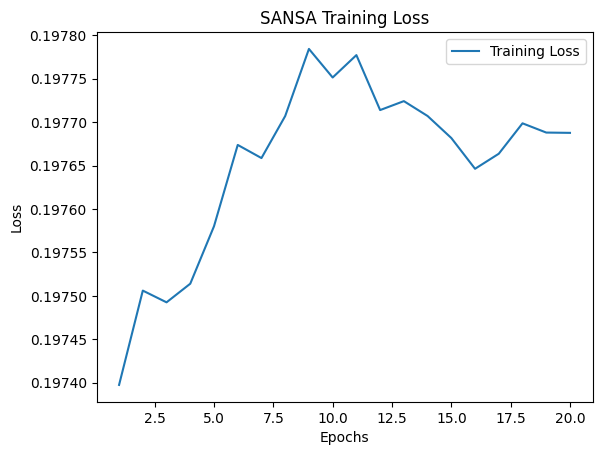

In [ ]:
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SANSA Training Loss")
plt.legend()
plt.show()


In [ ]:
class SANSA_CL(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=256, dropout=0.2):
        super(SANSA_CL, self).__init__()

        # Encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Projection head for contrastive space
        self.projection_head = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        projected = self.projection_head(encoded)
        decoded = self.decoder(encoded)
        return encoded, projected, decoded


In [ ]:
# Add this class definition to your code before the line that causes the error.
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        batch_size = z1.shape[0]
        z = torch.cat([z1, z2], dim=0)
        similarity_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z1.device)
        positive_samples = similarity_matrix[mask].view(2 * batch_size, -1)
        negative_samples = similarity_matrix[~mask].view(2 * batch_size, -1)

        logits = torch.cat([positive_samples, negative_samples], dim=1) / self.temperature
        labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z1.device)

        loss = F.cross_entropy(logits, labels)
        return loss

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming SANSA_CL, ContrastiveLoss, and other necessary classes are defined

# Initialize the SANSA_CL model
model_cl = SANSA_CL(input_dim, hidden_dim, latent_dim)
optimizer_cl = optim.Adam(model_cl.parameters(), lr=0.001)
criterion_cl = ContrastiveLoss() # Use ContrastiveLoss

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cl.to(device)

print(f"Model running on: {device}")

def train_sansa_cl(model, train_matrix, optimizer, criterion, epochs=20):
    model.train()

    # Move data to device
    train_matrix = train_matrix.to(device)

    losses_cl = [] # Initialize losses_cl to store losses

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        encoded, projected, decoded = model(train_matrix) # Get encoded and projected outputs

        # Calculate contrastive loss
        loss = criterion(encoded, projected) # Calculate loss using ContrastiveLoss

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses_cl.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    return losses_cl

# Train the model with contrastive learning
epochs = 20
losses_cl = train_sansa_cl(model_cl, train_matrix, optimizer_cl, criterion_cl, epochs) # Assign losses to losses_cl


Model running on: cuda
Epoch [5/20], Loss: 5.1962
Epoch [10/20], Loss: 5.0134
Epoch [15/20], Loss: 4.9524
Epoch [20/20], Loss: 4.9300


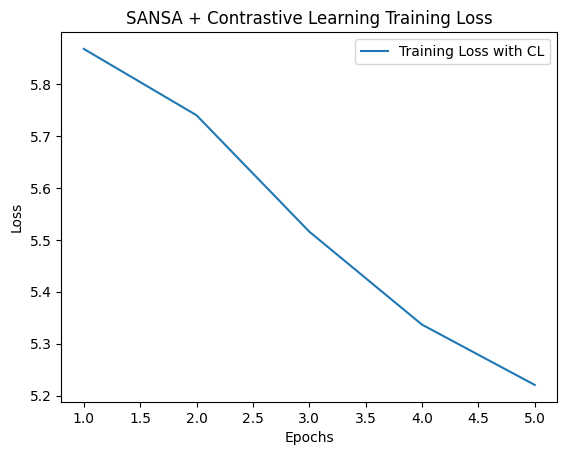

In [ ]:
plt.plot(range(1, epochs + 1), losses_cl, label="Training Loss with CL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SANSA + Contrastive Learning Training Loss")
plt.legend()
plt.show()


In [ ]:
def test_sansa(model, test_matrix, threshold=0.5):
    model.eval()
    with torch.no_grad():
        _, _, outputs = model(test_matrix.to(device))  # Get the decoded output from SANSA_CL
        preds = (outputs > threshold).float()  # Binarize predictions
    return preds

In [ ]:
# Get predictions and evaluate
predictions = test_sansa(model_cl, test_matrix) # Use model_cl for SANSA_CL evaluation
evaluate_sansa(predictions, test_matrix)
#evaluate_sansa function is in next box

Accuracy: 0.4998710306087355
Precision: 0.02251384338166566
Recall: 0.48873750137347544
F1 Score: 0.04304481415472456


In [ ]:
# Required libraries
#RL
import numpy as np
import scipy.sparse as sp
import random

# -------------- Step 1: Train Base SANSA ----------------
def train_sansa(X, lambda_reg=0.1):
    # Step 1: Compute Gram Matrix
    A = X.T @ X + lambda_reg * sp.eye(X.shape[1])

    # Step 2: Sparse Cholesky decomposition (simulated)
    # In practice use proper sparse Cholesky
    L = sp.tril(A)
    D = sp.diags(L.diagonal())

    # Step 3: Approximate Inverse
    K = sp.linalg.inv(L).tocsc()

    # Step 4: Build Encoder and Decoder
    W = K
    Z0 = sp.linalg.inv(D) @ W

    # Step 5: Column Scaling
    diag_elements = np.array((W.T @ Z0).diagonal()).flatten()
    Z = -Z0.multiply(1.0 / diag_elements)

    return W.T, Z

# -------------- Step 2: Initialize RL Policy ----------------
class RLPolicy:
    def __init__(self, n_items):
        self.n_items = n_items
        self.q_table = np.random.rand(n_items)

    def select_action(self, user_state):
        # ε-greedy policy
        if random.random() < 0.1:  # exploration
            return random.randint(0, self.n_items - 1)
        else:  # exploitation
            return np.argmax(self.q_table)

    def update(self, action, reward, lr=0.05, gamma=0.95):
        self.q_table[action] = (1 - lr) * self.q_table[action] + lr * (reward + gamma * np.max(self.q_table))

# -------------- Step 3: Interaction Loop ----------------
def simulate_user_feedback(action, true_items):
    # If action is in user's true liked items, reward = 1
    return 1 if action in true_items else 0

# -------------- Full Training ----------------
def train_sansa_with_rl(X, true_user_items, epochs=50):
    W, Z = train_sansa(X)
    n_items = X.shape[1]
    policy = RLPolicy(n_items)

    for epoch in range(epochs):
        total_reward = 0
        for user_idx in range(X.shape[0]):
            user_vector = X[user_idx].toarray().flatten()
            user_state = user_vector

            # Action: Recommend an item
            action = policy.select_action(user_state)

            # Simulate feedback
            reward = simulate_user_feedback(action, true_user_items[user_idx])

            # Policy update
            policy.update(action, reward)

            total_reward += reward

        print(f"Epoch {epoch+1}: Total Reward = {total_reward}")

    return W, Z, policy

# -------------- Step 4: Prediction ----------------
def predict(user_vector, W, Z, policy, top_k=5):
    scores = user_vector @ W @ Z
    scores = np.array(scores).flatten()
    recommended_items = np.argsort(scores)[::-1]
    return recommended_items[:top_k]

# -------------- Usage Example ----------------
if __name__ == "__main__":
    # Simulate sparse user-item matrix
    num_users = 10
    num_items = 50
    X = sp.random(num_users, num_items, density=0.1, format='csr')

    # Simulate ground-truth liked items
    true_user_items = [random.sample(range(num_items), k=5) for _ in range(num_users)]

    # Train SANSA + RL
    W, Z, policy = train_sansa_with_rl(X, true_user_items, epochs=20)

    # Predict for a random user
    test_user_idx = 0
    test_user_vector = X[test_user_idx].toarray()
    recommendations = predict(test_user_vector, W, Z, policy)

    print(f"Recommended items for User {test_user_idx}: {recommendations}")


Epoch 1: Total Reward = 1
Epoch 2: Total Reward = 2
Epoch 3: Total Reward = 2
Epoch 4: Total Reward = 2
Epoch 5: Total Reward = 2
Epoch 6: Total Reward = 2
Epoch 7: Total Reward = 2
Epoch 8: Total Reward = 2
Epoch 9: Total Reward = 2
Epoch 10: Total Reward = 2
Epoch 11: Total Reward = 2
Epoch 12: Total Reward = 2
Epoch 13: Total Reward = 0
Epoch 14: Total Reward = 1
Epoch 15: Total Reward = 2
Epoch 16: Total Reward = 2
Epoch 17: Total Reward = 2
Epoch 18: Total Reward = 2
Epoch 19: Total Reward = 2
Epoch 20: Total Reward = 3
Recommended items for User 0: [ 6 24 36 22 49]


/usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Ainv = spsolve(A, I)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(user_vector, W, Z, policy, true_items, top_k=5):
    scores = user_vector @ W @ Z
    scores = np.array(scores).flatten()

    # Recommend Top-K items
    recommended_items = np.argsort(scores)[::-1][:top_k]

    # Prepare true labels
    y_true = np.zeros(len(scores))
    for item in true_items:
        y_true[item] = 1  # relevant items are marked 1

    # Prepare predicted labels
    y_pred = np.zeros(len(scores))
    for item in recommended_items:
        y_pred[item] = 1  # recommended top-K items

    # Now calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

    return precision, recall, accuracy, f1
